In [22]:
import numpy as np

from panels import Shell
from panels.models.cylshell_clpt_donnell_bardell_koiter import (
    fkoiter, fphi2Matrix)

s = Shell()
s.stack = [0, 90, 90, 0]
s.plyt = 0.1/4
s.laminaprop = (4.2e7, 2.1e6, 0.25, 1.26e6, 1.26e6, 1.26e6)
s.model = 'cylshell_clpt_donnell_bardell'
s.a = 10
s.b = 10
s.r = 1.e15
s.out_num_cores = 8

s.m = 6
s.n = 6
s.nx = s.m
s.ny = s.n

NxxHAT = 1
NLgeom = True

s.w1rx = 1
s.w2rx = 1
s.w1ry = 1
s.w2ry = 1

s.u1tx = 1
s.u1ty = 1
s.u2ty = 1

s.u1rx = 1
s.u2rx = 1
s.u1ry = 1
s.u2ry = 1

s.v1tx = 1
s.v2tx = 0
s.v1ty = 1
s.v2ty = 1
s.v1rx = 1
s.v2rx = 1
s.v1ry = 1
s.v2ry = 1

s.add_distr_load_fixed_x(0, lambda y: NxxHAT, None, None)
     
c0 = s.static(NLgeom=False, silent=True)[0]

eigvals, eigvecs = s.lb(c=c0)
LCR = eigvals[0]
c1 = eigvecs[:, 0]
c1 /= np.linalg.norm(c1)

from panels.plot_shell import plot_shell
if False:
    plot_shell(s, c0, filename='plot_static_u.png',
               clean=False, colorbar=True, vec='u')
    plot_shell(s, c0, filename='plot_static_v.png',
               clean=False, colorbar=True, vec='v')
    plot_shell(s, c0, filename='plot_static_exx.png',
               clean=False, colorbar=True, vec='exx')
    plot_shell(s, c0, filename='plot_static_kxx.png',
               clean=False, colorbar=True, vec='kxx')


plot_shell(s, c1, filename='plot_c1.png',
           clean=False, colorbar=True, vec='w')

# first call to compute lambda_1 and c2
print('First Koiter computations...')
out = fkoiter(LAMBDA=LCR, NxxHAT=NxxHAT,
              c0=c0, cA=c1, cB=c1, cC=c1, cD=c1,
              Finput=s.F, shell=s, nx=s.nx, ny=s.ny, NLgeom=NLgeom)

print('Computing phi2Matrix...')
phi2Matrix = fphi2Matrix(LCR, NxxHAT, c0, s.F, s, s.get_size(), 0, 0, s.nx, s.ny, NLgeom)

lambda1 = -1/2*out['phi3'] / out['phi2o']

c2bar = c1*phi2Matrix*(-lambda1*out['phi2o'] - 1/2*out['phi3'])
c2 = c2bar - c1*np.dot(c2bar, c1)
try:
    plot_shell(s, c2, filename='plot_c2.png',
               clean=False, colorbar=True, vec='w')
except:
    pass

# second call to compute lambda_2
print('Second Koiter computations...')
out2 = fkoiter(LAMBDA=LCR, NxxHAT=NxxHAT,
               c0=c0, cA=c1, cB=c2, cC=c1, cD=c1,
               Finput=s.F, shell=s, nx=s.nx, ny=s.ny, NLgeom=NLgeom)

lambda2 = -(1/6*out['phi4'] + lambda1*out2['phi2o'] 
           + 1/2*lambda1**2*out['phi2'] + out2['phi3']) / out['phi2o']

print('lambda2', lambda2, s.get_size())

Running linear buckling analysis...
		Eigenvalue solver... 
		Calculating kG... 
		finished!
		Calculating kC... 
		finished!
			eigsh() solver...
			aborted!
			Removing null columns...
				32 columns removed
			finished!
			eigsh() solver...
			finished!
		finished!
	first 5 eigenvalues:
		414.07055840998134
		1295.0289640605674
		1448.294051398921
		1666.1987104962916
		4352.146264015863
Plotting contour...
	Computing field variables...
	Finished!
finished!
First Koiter computations...
Computing phi2Matrix...
Plotting contour...
	Computing field variables...
	Finished!
Second Koiter computations...
lambda2 27.15374351057338 108


In [18]:
out

{'phi2': -15.958986979338311,
 'phi2o': -0.04332140766854483,
 'phi3': -4.779198874462947e-14,
 'phi4': 7.058030354090033}

In [19]:
lambda1 / LAMBDA

-1.3321348661832765e-15

In [20]:
lambda2 / LAMBDA

0.06557757599293451

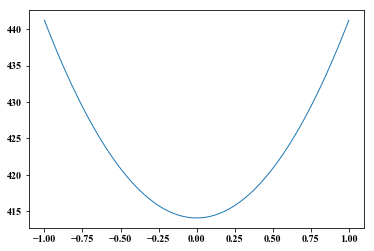

In [21]:
import matplotlib.pyplot as plt

xis = np.linspace(-1, 1, 100) 

plt.plot(xis, LAMBDA + xis*lambda1 + xis**2*lambda2)
plt.show()